<a href="https://colab.research.google.com/github/AACRobinson/IMLO-Assessment/blob/main/IMLO_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialisation**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io
import sklearn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode
from torch import nn
from torch.utils.data import DataLoader


if torch.cuda.is_available() :
  torch.cuda.empty_cache()
  device = 'cuda'
elif torch.backends.mps.is_available() :
  torch.backends.mps.empty_cache()
  device = 'mps'
else:
  torch.cpu.empty_cache()
  device = 'cpu'

print("Using", device, "device\n")


trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=Compose([ToTensor(), Resize((500, 500))]) #Need to convert all images to the same tensor dimensions, and we want these images to be small enough to make sure memory doesn't fill up
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=Compose([ToTensor(), Resize((500, 500))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=Compose([ToTensor(), Resize((500, 500))])
)

trainDataLoader = DataLoader(trainFlowers, batch_size=16, shuffle=True)
validateDataLoader = DataLoader(validateFlowers, batch_size=16, shuffle=True)
testDataLoader = DataLoader(testFlowers, batch_size=16, shuffle=True)

Using cuda device



# **Visualisation**

<ipython-input-2-25d4dbbbb16d>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 500, 500) -> (500, 500, 3)


Feature batch shape:  torch.Size([64, 3, 500, 500])
Labels batch shape:  torch.Size([64])


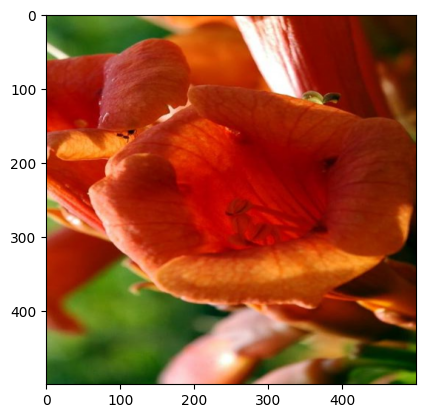

Label:  100


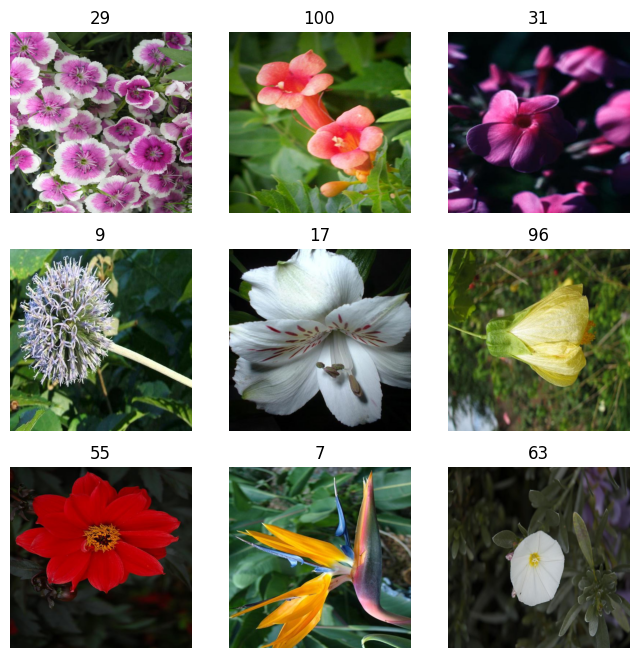

In [2]:
train_features, train_labels = next(iter(trainDataLoader))
print("Feature batch shape: ", train_features.size())
print("Labels batch shape: ", train_labels.size())
image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 500, 500) -> (500, 500, 3)
label = train_labels[0].item()
plt.imshow(image)
plt.show()
print("Label: ", label)


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1) :
  sample_index = torch.randint(len(trainFlowers), size=(1,)).item()
  image, label = trainFlowers[sample_index]
  figure.add_subplot(rows, cols, i)
  plt.title(trainFlowers[sample_index][1])
  plt.axis("off")
  plt.imshow(image.squeeze().T)
plt.show()

# **Building the NN**

In [26]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*500*500, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 102),
        )

    def forward(self, x):
        x = self.flatten(x).to(device)
        logits = self.linear_relu_stack(x).to(device)
        return logits

flowerNNModel = flowerNN().to(device)
modelLR = 0.001
epochs = 100
lossFunct = nn.CrossEntropyLoss().to(device)
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    y = y.to(device)
    loss = lossFunct(prediction, y)
    loss.backward()
    modelOptimiser.step()
    modelOptimiser.zero_grad()
    if modelBatch % dataloader.batch_size == 0 :
      loss, current = loss.item(), modelBatch * dataloader.batch_size + len(X)
      print("Loss: ", round(loss, 2), "(", current, "/", len(dataloader.dataset), ")")

def evaluator(dataloader, nnModel, lossFunct):
    nnModel.eval()
    dataSize = len(dataloader.dataset)
    numBatches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prediction = nnModel(X)
            y = y.to(device)
            loss += lossFunct(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    loss /= numBatches
    correct /= dataSize
    print("Test Error: \n Accuracy: ", round((100*correct), 2), "\n Avg loss: ", round(loss, 2), "\n")

for t in range(epochs):
    print("Epoch ", t+1, "\n-------------------------------")
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimiser)
    evaluator(validateDataLoader, flowerNNModel, lossFunct)
print("Final Evaluation ", "\n-------------------------------")
evaluator(testDataLoader, flowerNNModel, lossFunct)
print("Done!\n\n")

Epoch  1 
-------------------------------
Loss:  4.62 ( 16 / 1020 )
Loss:  4.62 ( 272 / 1020 )
Loss:  4.63 ( 528 / 1020 )
Loss:  4.62 ( 784 / 1020 )
Test Error: 
 Accuracy:  1.37 
 Avg loss:  4.62 

Epoch  2 
-------------------------------
Loss:  4.61 ( 16 / 1020 )
Loss:  4.6 ( 272 / 1020 )
Loss:  4.61 ( 528 / 1020 )
Loss:  4.61 ( 784 / 1020 )
Test Error: 
 Accuracy:  2.55 
 Avg loss:  4.6 

Epoch  3 
-------------------------------
Loss:  4.63 ( 16 / 1020 )
Loss:  4.61 ( 272 / 1020 )
Loss:  4.58 ( 528 / 1020 )
Loss:  4.6 ( 784 / 1020 )
Test Error: 
 Accuracy:  3.43 
 Avg loss:  4.59 

Epoch  4 
-------------------------------
Loss:  4.55 ( 16 / 1020 )
Loss:  4.56 ( 272 / 1020 )
Loss:  4.54 ( 528 / 1020 )
Loss:  4.53 ( 784 / 1020 )
Test Error: 
 Accuracy:  4.8 
 Avg loss:  4.57 

Epoch  5 
-------------------------------
Loss:  4.53 ( 16 / 1020 )
Loss:  4.54 ( 272 / 1020 )
Loss:  4.51 ( 528 / 1020 )
Loss:  4.52 ( 784 / 1020 )
Test Error: 
 Accuracy:  4.12 
 Avg loss:  4.55 

Epoch  6 

KeyboardInterrupt: 